# Project: Wrangling and Analyze Data

In [1]:
#loads the autocompleter
%config Completer.use_jedi = False

#import all needed packages
import pandas as pd
pd.set_option('display.max_colwidth', None)
import requests
import os
import tweepy
import json
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
#load and confirm the WeRateDogs Twitter archive file
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# Download the prediction data
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [4]:
#read and confirm the downloaded file
df_prediction = pd.read_csv('image-predictions.tsv',sep='\t')
df_prediction.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [23]:
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_archive.tweet_id.values

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
            break
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Fail
1.548882400000366
{892420643555336193: Unauthorized('401 Unauthorized\n89 - Invalid or expired token.',)}


In [5]:
# Read the JSON file then convert it into a dataframe
json_tmp = []
with open('tweet-json.txt') as jsonfile:
    for ln in jsonfile:
        tweet = (json.loads(ln))
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        created_at = tweet['created_at']
        json_tmp.append({'retweet_count' : retweet_count,
                  'favorite_count' : favorite_count,
                  'created_at' : created_at,
                  'tweet_id' : tweet_id})
        
extraData = pd.DataFrame(json_tmp, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'created_at'])

In [6]:
#confirm the extraction was successful
extraData.head(2)

,tweet_id,retweet_count,favorite_count,created_at
0,892420643555336193,8853,39467,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,6514,33819,Tue Aug 01 00:17:27 +0000 2017


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [11]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


#### Visual Assessment
1. `Quality Issue` I see some rows with replies and retweet.
2. `Tidy issue` The dog stages should be in a column.

#### Programmatic Assessment below

In [12]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [7]:
# Checking for replies and retweets
df_archive[(df_archive.in_reply_to_status_id.notnull() | (df_archive.retweeted_status_id.notnull()))].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None


In [8]:
# Checking for missing Data
df_archive.expanded_urls.isnull().sum()

59

In [9]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
# Check for denominator ratings that isn't 10
df_archive[df_archive.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184

#### Visual Assessment
1. The prediction and algorithm confidence should have just 3 columns.

In [11]:
df_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Count of tweets with images

In [13]:
print('Number of tweets with images is %s'%(len(list(df_prediction.tweet_id.values))))

Number of tweets with images is 2075


In [14]:
df_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [15]:
# Checking for non dogs
df_prediction[((df_prediction.p1_dog == False) & (df_prediction.p2_dog == False) & (df_prediction.p3_dog == False))].head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False


In [16]:
extraData.head()

,tweet_id,retweet_count,favorite_count,created_at
0,892420643555336193,8853,39467,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,6514,33819,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,4328,25461,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,8964,42908,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,9774,41048,Sat Jul 29 16:00:24 +0000 2017


In [17]:
extraData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   int64 
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
 3   created_at      2354 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


In [20]:
extraData.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


#### Visual Assessment

1. retweet and favorite count should be in a colum

In [19]:
(df_archive.rating_denominator != 10).sum()
print('Number of tweets not equal 10 = %s' %(df_archive.rating_denominator != 10).sum())

Number of tweets not equal 10 = 23


#### Verify the dataframe captures duration not exceeding August 01 2017

In [ ]:
archive_clean.timestamp.min(), archive_clean.timestamp.max()

### Quality issues
#### `Twitter Archive` Tables
1. Only 2075 tweets have images 

2. missing values(in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_timestamp and expanded_urls)

3. Some rows contains retweets and replies.

4. Erroneous datatypes (tweet_id, timestamp, in_reply_to_status_id, in_reply_to_user_id,retweeted_status_id, retweeted_status_user_id, retweeted_status_user_id)

5. Outliers (rating_numerator, rating_denominator)

6. About 23 Denominators are not equal 10 and Dog name and stages are also unknown.

7. source columns contains html tags

#### `Prediction` Tables
8. Not all the rows contain dogs

9. jpg_url contains 2 png files instead of jpg only

10. Erroneous datatypes (tweet_id)

#### `extradata` Tables

11. Erroneous datatypes (tweet_id, created_at)

#### `archive` Tables

12. Null represented as "None" in doggo, floofer, pupper and puppo

### Tidiness issues

#### `extraData` Tables
1. extraData should be part of df_archive table

2. Retweet and Favorite should be in a column

#### `df_archive` Tables

3. Doggo, floofer, pupper and puppo should be in a column

4. Retweet and reply columns not needed.


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [21]:
# Make copies of original pieces of data
archive_clean = df_archive.copy()
prediction_clean = df_prediction.copy()

extraData_clean = extraData.copy()

### Issue #1: 
Only 2075 tweets have images 
#### `archive_clean Table` 

#### Define:
Confirm that the tweet ID in archive_clean is also inside prediction dataframes then extract only those with images.

#### Code

In [22]:
# crosschecking both dataframes
pre_list = list(prediction_clean.tweet_id.values)
archive_clean = archive_clean[archive_clean.tweet_id.isin(pre_list)]

#### Test

In [23]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2075 non-null   object 
 13  doggo                       2075 

### Issue #2  & #3: 
missing values (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_timestamp and expanded_urls) __&__ rows with tweets and retweets
#### `archive_clean Table` 

#### Define:
Since we want Original tweets only, then rows containing retweets and replies will be dropped. expanded url with null shall also be dropped

#### Code

In [24]:
#drop rows with reply
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isnull()]
#drop rows with retweets
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

#### Test

Confirms no retweets, replies or tweets with null expanded url

In [25]:
archive_clean[(archive_clean.in_reply_to_status_id.notnull() | (archive_clean.retweeted_status_id.notnull()) | (archive_clean.expanded_urls.isnull()))].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [26]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1971 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1971 non-null   object 
 4   source                      1971 non-null   object 
 5   text                        1971 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1971 non-null   object 
 10  rating_numerator            1971 non-null   int64  
 11  rating_denominator          1971 non-null   int64  
 12  name                        1971 non-null   object 
 13  doggo                       1971 

 Zero means we have successfully removed all replies/retweets from our dataset.

### Issue # 4:

Erroneous datatypes (tweet_id, timestamp, in_reply_to_status_id, in_reply_to_user_id,retweeted_status_id, retweeted_status_user_id, retweeted_status_user_id)

`archive_clean Table`

#### Define 

convert `tweet_id` to __string__ and `timestamp` to __datatime__ . The other columns won't be converted since they will be dropped during the tidy stage.

#### Code

In [27]:
# Datatype conversion
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype(str)
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test

In [28]:
# check Datatypes
archive_clean.tweet_id.dtype, archive_clean.timestamp.dtype

(dtype('O'), datetime64[ns, UTC])

### Issue #5 & #6: 
Outliers (rating_numerator, rating_denominator) & About 23 Denominators are not equal 10 and Dog name and stages are also unknown

`archive_clean Table`

#### Define

The denominators that are not 10 shall be investigated to see if it's an error and needs to be dropped. 

#### Code: 

In [30]:
# confirms lenght of rows not equal 10
len(archive_clean[archive_clean.rating_denominator != 10])

17

In [31]:
archive_clean[archive_clean.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">

In [33]:
# Fix manually columns that has wrong ratings
archive_clean.loc[archive_clean['tweet_id'] == '740373189193256964', ['rating_numerator','rating_denominator']] = [14,10]
archive_clean.loc[archive_clean['tweet_id'] == '722974582966214656', ['rating_numerator','rating_denominator']] = [13,10]
archive_clean.loc[archive_clean['tweet_id'] == '716439118184652801', ['rating_numerator','rating_denominator']] = [11,10]
archive_clean.loc[archive_clean['tweet_id'] == '682962037429899265', ['rating_numerator','rating_denominator']] = [10,10]
archive_clean.loc[archive_clean['tweet_id'] == '666287406224695296', ['rating_numerator','rating_denominator']] = [9,10]
archive_clean.loc[archive_clean['tweet_id'] == '786709082849828864', ['rating_numerator','rating_denominator']] = [9.75,10]
archive_clean.loc[archive_clean['tweet_id'] == '778027034220126208', ['rating_numerator','rating_denominator']] = [11.27,10]
archive_clean.loc[archive_clean['tweet_id'] == '680494726643068929', ['rating_numerator','rating_denominator']] = [11.26,10]

In [34]:
len(archive_clean[archive_clean.rating_denominator != 10])

12

In [35]:
archive_clean = archive_clean[archive_clean.rating_denominator == 10]

#### Test

In [38]:
# confirm the manual fix was successful
archive_clean.loc[(archive_clean['tweet_id'] == '740373189193256964') | (archive_clean['tweet_id'] == '722974582966214656')|(archive_clean['tweet_id'] == '716439118184652801')| (archive_clean['tweet_id'] == '682962037429899265') |
(archive_clean['tweet_id'] == '666287406224695296')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14.0,10,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,13.0,10,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118184652801/photo/1,11.0,10,Bluebert,None,None,None,None
1662,682962037429899265,NaN,NaN,2016-01-01 16:30:13+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037429899265/photo/1,10.0,10,Darrel,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9.0,10,an,None,None,None,None


In [40]:
# verify all non dogs have been removed
len(archive_clean[archive_clean.rating_denominator != 10])

0

### Issue #7: 
source columns contains html tags

`archive_clean Table`

#### Define 

Remove all Html tags and attributes

#### Code

In [42]:
#prints value count for the sources
archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1920
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [43]:
# Extract the string from the html tags
archive_clean.source = archive_clean.source.str.extract('(Twitter for iPhone|Twitter Web Client|TweetDeck)',expand=True)

#### Test

In [44]:
archive_clean.source.value_counts()

Twitter for iPhone    1920
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

### Issue #8: 

Erroneous datatypes (tweet_id)

`Prediction_clean Table`

#### Define:
convert tweet_id to string .

#### Code

In [47]:
# Datatype conversion
prediction_clean['tweet_id'] = prediction_clean['tweet_id'].astype(str)

#### Test

In [48]:
prediction_clean.tweet_id.dtype

dtype('O')

### Issue #9: 
`Prediction_clean Table`

Not all rows contains dogs

#### Define
filter out the non dogs then compare the archive dataframe with the updated prediction table

#### Code

In [54]:
#confirms count of non dogs
dogs = prediction_clean[~((prediction_clean.p1_dog == False) & (prediction_clean.p2_dog == False) & (prediction_clean.p3_dog == False))]
test = list(dogs.tweet_id.values)
len(test)

1751

In [55]:
# Exclude all non dogs
archive_clean = archive_clean[archive_clean.tweet_id.isin(test)]

#### Test:

In [56]:
archive_clean.tweet_id.count()

1655

### Issue #10: 
jpg_url contains 2 png files instead of jpg only

`Prediction_clean Table`

#### Define
Filter out rows that contains the png files.

#### Code

In [57]:
# filter out png files
prediction_clean = prediction_clean[prediction_clean.jpg_url.str.contains('jpg')]

#### Test

In [58]:
prediction_clean[~prediction_clean.jpg_url.str.contains('jpg')]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Issue #11:
Erroneous datatypes (tweet_id, created_at)

`ExtraData_clean Table`

#### Define:
convert tweet_id to string and created_at to datetime.

#### Code

In [59]:
# Datatype conversion
extraData_clean['tweet_id'] = extraData_clean['tweet_id'].astype(str)
extraData_clean['created_at'] = pd.to_datetime(extraData_clean['created_at'])

#### Test

In [60]:
extraData_clean.tweet_id.dtype,extraData_clean.created_at.dtype

(dtype('O'), datetime64[ns, UTC])

### Issue #12: 

`archive Tables`

Null represented as "None" in doggo, floofer, pupper and puppo

#### Define

replace the "None" with np.nan

#### Code

In [61]:
#replace non with np.nan
dogs_stage = ['doggo', 'floofer', 'pupper', 'puppo']
archive_clean[dogs_stage] = archive_clean[dogs_stage].replace('None',np.nan)

## Tidy Issues

### Issue # 1: 

`archive_clean Tables`

extraData should be part of df_archive table

####  Define:
merge the extraData_clean table with the archive_clean table joining on tweet_id

####  Code:

In [62]:
archive_clean = pd.merge(archive_clean,extraData_clean,on= 'tweet_id',how='left')

#### Test

In [ ]:
list(archive_clean)

### Issue # 2: 

`extraData_clean Tables`

Retweet and Favorite should be in a column

#### Define

Melt the Retweet and Favorite count 2 columns "Tweet_Type" and "Count""

#### Code

In [ ]:
extraData_clean = pd.melt(extraData_clean, id_vars=['tweet_id'],value_vars=['retweet_count','favorite_count'],var_name='Tweet_Type',value_name='Count')

#### Test

In [ ]:
extraData_clean

### Issue #3: 

`archive Tables`

Merge Doggo, floofer, pupper and puppo should be in a column

#### Define

Merge all the four columns then investigate any with dual names then fix

#### Code

In [63]:
# join the 4 dog stage columns
archive_clean['stage'] = archive_clean[['doggo', 'floofer','pupper','puppo']].fillna('').agg(''.join, axis=1)

In [65]:
#Replace the space with Null value then show the count for each dog group
archive_clean['stage'] = archive_clean.stage.replace('',np.nan)
archive_clean.stage.value_counts()

pupper          166
doggo            54
puppo            21
doggopupper       7
floofer           7
doggopuppo        1
doggofloofer      1
Name: stage, dtype: int64

In [67]:
# Manually investigate the type of dog
archive_clean[archive_clean.stage == "doggopupper"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,created_at,stage
302,817777686764523521,NaN,NaN,2017-01-07 16:59:28+00:00,Twitter for iPhone,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,...,10,Dido,doggo,NaN,pupper,NaN,3084,11901,2017-01-07 16:59:28+00:00,doggopupper
355,808106460588765185,NaN,NaN,2016-12-12 00:29:28+00:00,Twitter for iPhone,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,...,10,None,doggo,NaN,pupper,NaN,2525,9701,2016-12-12 00:29:28+00:00,doggopupper
377,801115127852503040,NaN,NaN,2016-11-22 17:28:25+00:00,Twitter for iPhone,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",...,10,Bones,doggo,NaN,pupper,NaN,2429,8992,2016-11-22 17:28:25+00:00,doggopupper
577,759793422261743616,NaN,NaN,2016-07-31 16:50:42+00:00,Twitter for iPhone,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",...,10,Maggie,doggo,NaN,pupper,NaN,2173,6620,2016-07-31 16:50:42+00:00,doggopupper
622,751583847268179968,NaN,NaN,2016-07-09 01:08:47+00:00,Twitter for iPhone,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751583847268179968/photo/1,...,10,None,doggo,NaN,pupper,NaN,1265,4849,2016-07-09 01:08:47+00:00,doggopupper
698,741067306818797568,NaN,NaN,2016-06-10 00:39:48+00:00,Twitter for iPhone,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/741067306818797568/photo/1,...,10,just,doggo,NaN,pupper,NaN,3520,10342,2016-06-10 00:39:48+00:00,doggopupper
739,733109485275860992,NaN,NaN,2016-05-19 01:38:16+00:00,Twitter for iPhone,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",NaN,NaN,NaN,https://twitter.com/dog_rates/status/733109485275860992/photo/1,...,10,None,doggo,NaN,pupper,NaN,17621,44619,2016-05-19 01:38:16+00:00,doggopupper


In [68]:
# Manually investigate the type of dog
archive_clean[archive_clean.stage == "doggofloofer"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,created_at,stage
138,854010172552949760,NaN,NaN,2017-04-17 16:34:26+00:00,Twitter for iPhone,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",...,10,None,doggo,floofer,NaN,NaN,3433,17169,2017-04-17 16:34:26+00:00,doggofloofer


In [69]:
# fix the group with the appropriate name
archive_clean['stage'] = archive_clean.stage.replace('doggofloofer','floofer')

In [70]:
# Manually investigate the type of dog
archive_clean[archive_clean.stage == "doggopuppo"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,created_at,stage
132,855851453814013952,NaN,NaN,2017-04-22 18:31:02+00:00,Twitter for iPhone,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,...,10,None,doggo,NaN,NaN,puppo,19196,47844,2017-04-22 18:31:02+00:00,doggopuppo


In [71]:
# Fix the name
archive_clean['stage'] = archive_clean.stage.replace('doggopuppo','pupper')

#### Test

In [72]:
archive_clean.stage.value_counts()

pupper         167
doggo           54
puppo           21
floofer          8
doggopupper      7
Name: stage, dtype: int64

In [74]:
# fix the data type
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].astype(int)
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1655 entries, 0 to 1654
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1655 non-null   object             
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1655 non-null   datetime64[ns, UTC]
 4   source                      1655 non-null   object             
 5   text                        1655 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1655 non-null   object             
 10  rating_numerator            1655 non-null   int32           

### Issue #4: 

`archive Tables`

Retweet,reply,Doggo,floofer,pupper and puppo columns not needed.

#### Define

Drop the Retweet,reply,text, created_at and all other unneccessary columns for our insight

#### Code

In [75]:
archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','text','retweeted_status_user_id','retweeted_status_timestamp','created_at','doggo','floofer','pupper','puppo','expanded_urls'], axis= 1, inplace= True)

#### Test

In [76]:
list(archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweet_count',
 'favorite_count',
 'stage']

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

#### Code

In [78]:
# convert the cleaned and merged archive to a master file 
archive_clean.to_csv('twitter_archive_master.csv',index=False)

#### Test

In [79]:
df = pd.read_csv('twitter_archive_master.csv')
df.sample(5)

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage
1507,669375718304980992,2015-11-25 04:43:02+00:00,Twitter for iPhone,6,10,Billl,792,1425,NaN
183,841077006473256960,2017-03-13 00:02:39+00:00,Twitter for iPhone,12,10,Dawn,5991,24926,NaN
241,829011960981237760,2017-02-07 17:00:28+00:00,Twitter for iPhone,13,10,Dexter,18627,58302,NaN
402,794926597468000259,2016-11-05 15:37:24+00:00,Twitter for iPhone,12,10,Mack,2697,11492,NaN
344,810896069567610880,2016-12-19 17:14:23+00:00,Twitter for iPhone,11,10,Hunter,2090,10093,NaN


## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1. Percentage distribution of the known dog stages

2. Percentage distribution of tweet sources

3. Known Dog stage with the best rating

#### 1. Percentage distribution of the known dog stages

In [80]:
total = df['stage'].value_counts(dropna=False)
percent = df['stage'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
cnt = pd.concat([total,percent], axis=1, keys=['Total', 'percent'])
cnt

,Total,percent
NaN,1398,NaN
pupper,167,64.98%
doggo,54,21.01%
puppo,21,8.17%
floofer,8,3.11%
doggopupper,7,2.72%


#### 2. Percentage distribution of tweet sources

In [81]:
total = df['source'].value_counts()
percent = df['source'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
cnt = pd.concat([total,percent], axis=1, keys=['Total', 'percent'])
cnt

,Total,percent
Twitter for iPhone,1624,98.13%
Twitter Web Client,22,1.33%
TweetDeck,9,0.54%


#### 3. Known Dog stage with the best rating

In [82]:
df.groupby(['stage']).rating_numerator.value_counts().sort_values(ascending =False)

stage        rating_numerator
pupper       11                  45
             12                  42
             10                  39
doggo        13                  17
pupper       9                   14
             13                  13
doggo        11                  13
             12                  12
puppo        13                   8
pupper       8                    7
puppo        12                   6
doggopupper  12                   5
doggo        10                   5
             14                   5
pupper       14                   4
             7                    3
puppo        10                   3
floofer      13                   3
doggo        8                    2
floofer      12                   2
             11                   2
puppo        11                   2
doggopupper  5                    1
             13                   1
floofer      10                   1
puppo        9                    1
             14                   

### Visualization

#### 1: Top 10 ratings for the dog stages with the higest counts

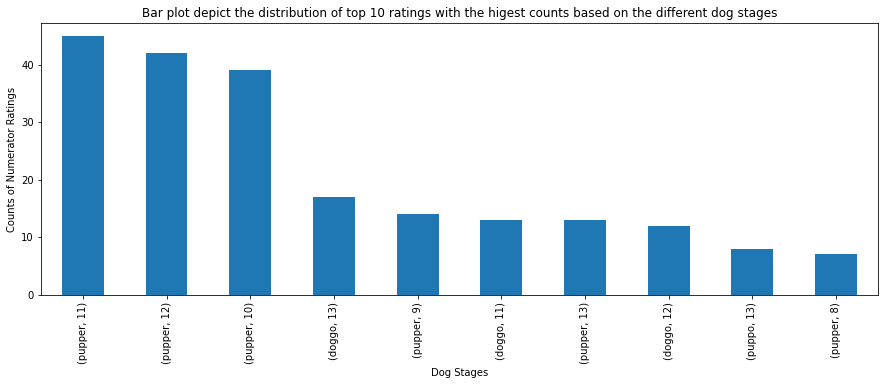

In [83]:
# plots a bar chart of the top 10 ratings for the dog stages with the higest counts.)
ax= (df.groupby('stage').rating_numerator.value_counts().nlargest(10).plot(kind='bar',
                                                                                      figsize=(15,5),
                                                                                      xlabel ="Dog Stages",
                                                                                      ylabel= "Counts of Numerator Ratings",
                                                                                      title ="Bar plot depict the distribution of top 10 ratings with the higest counts based on the different dog stages"))


#### 2: Percentage distribution of the known dog stages

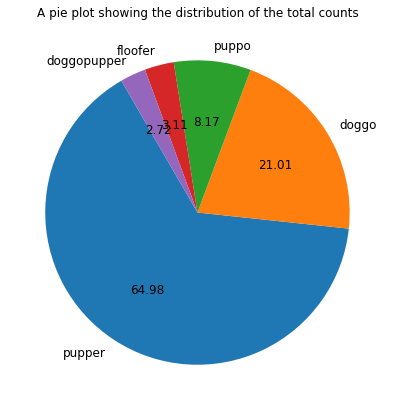

In [84]:
df['stage'].value_counts().plot.pie(autopct='%.2f', figsize=(18,7),
 startangle=120, fontsize=12, label ="",title ="A pie plot showing the distribution of the total counts");


#### 3: Correlation between the numerator ratings and the favorite counts

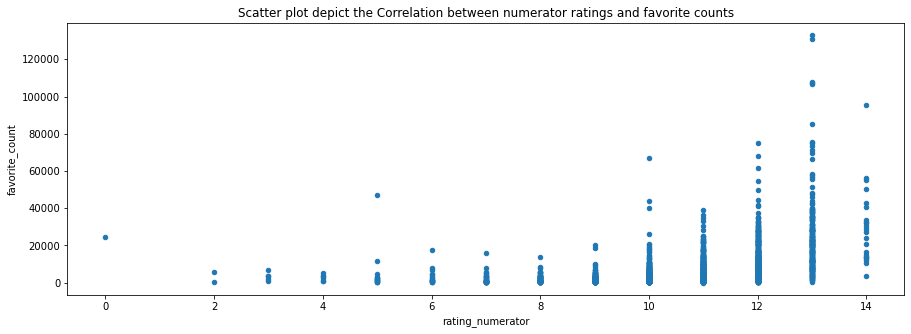

In [85]:
df.plot.scatter(x='rating_numerator',
                y='favorite_count',
                figsize=(15,5),
                title="Scatter plot depict the Correlation between numerator ratings and favorite counts",
                xlabel="numerator ratings ",
                ylabel="Counts of Numerator Ratings");